In [1]:
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
import glob
import random
import json
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms as T
import segmentation_models_pytorch as smp
from tqdm import tqdm
import cv2

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.manual_seed(1)
random.seed(1)
np.random.seed(2)
#torch.use_deterministic_algorithms(True)
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(2)

In [3]:
val = glob.glob('/workspace/jay/DDP/Ocelot/yolo_binary/datasets/cell_detect_33-1/valid/images/*.jpg')
test = glob.glob('/workspace/jay/DDP/Ocelot/yolo_binary/datasets/cell_detect_33-1/test/images/*.jpg')
val_files = np.unique(np.array([x.split('/')[-1][:3] for x in val]))
test_files = np.unique(np.array([x.split('/')[-1][:3] for x in test]))
val_set = list(val_files)+list(test_files)

In [4]:
class Ocelot(Dataset):
    def __init__(self,val=False):
        self.val = val
        temp = glob.glob('/workspace/jay/DDP/Ocelot/ocelot2023/images/train/cell/*.jpg')
        self.cell_imgs = [x for x in temp if x.split('/')[-1][:3] not in val_set]
        self.val_imgs = [x for x in temp if x.split('/')[-1][:3] in val_set]
        self.tissue_imgs = [x.replace('cell','tissue') for x in self.cell_imgs]
        self.tissue_val_imgs = [x.replace('cell','tissue') for x in self.val_imgs]

        self.masks = ['/workspace/jay/DDP/Ocelot/ocelot2023/cell_seg_masks/'+x.split('/')[-1][:3]+'.npy' for x in self.cell_imgs]
        self.val_masks = [f'/workspace/jay/DDP/Ocelot/ocelot2023/cell_seg_masks/'+x.split('/')[-1][:3]+'.npy' for x in self.val_imgs]
        
    def __len__(self): 
        if self.val:
            return len(self.val_imgs)
        else:
            return len(self.cell_imgs)

    def __getitem__(self, idx):
        
        if self.val:
            file = self.val_imgs[idx]
            mask = self.val_masks[idx]
            tissue = self.tissue_val_imgs[idx]
        else:
            file = self.cell_imgs[idx]
            mask = self.masks[idx]
            tissue = self.tissue_imgs[idx]
            
        name = file.split('/')[-1].split('.')[0]
        cell = Image.open(file)
        tissue = Image.open(tissue)
        mask = torch.Tensor(np.load(mask))
        
        if not self.val:
            if random.uniform(0, 1)>0.5:
                tissue = T.functional.hflip(tissue)
                cell = T.functional.hflip(cell)
                mask = T.functional.hflip(mask)
            if random.uniform(0, 1)>0.5:
                rot = random.uniform(0,1)
                if rot<0.5 and rot>=0.25:
                    tissue = T.functional.rotate(tissue,angle=90)
                    cell = T.functional.rotate(cell,angle=90)
                    mask = T.functional.rotate(mask,angle=90)
                elif rot>=0.5 and rot<0.75:
                    tissue = T.functional.rotate(tissue,angle=180)
                    cell = T.functional.rotate(cell,angle=180)
                    mask = T.functional.rotate(mask,angle=180)
                elif rot>=0.75 and rot<=1:
                    tissue = T.functional.rotate(tissue,angle=270)
                    cell = T.functional.rotate(cell,angle=270)
                    mask = T.functional.rotate(mask,angle=270)
            if random.uniform(0, 1)>0.5:
                cell = T.functional.adjust_brightness(cell, 0.1)
                cell = T.functional.adjust_contrast(cell,0.1)
                cell = T.functional.adjust_saturation(cell,0.1)
                cell = T.functional.adjust_hue(cell,0.1)
                
        cell = np.array(cell)
        cell = cell / 255
        cell = cell - 0.5
        cell = torch.Tensor(np.moveaxis(cell, -1, 0))
        tissue = (np.array(tissue)/255) - 0.5
        tissue = torch.Tensor(np.moveaxis(tissue, -1, 0))
    
        return tissue,cell,mask,name
        

In [5]:
device = 'cuda:2'

# model = smp.UnetPlusPlus(
#     encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#     encoder_weights='imagenet',     # use `imagenet` pre-trained weights for encoder initialization
#     in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#     classes=3,                      # model output channels (number of classes in your dataset)
# )
model = smp.DeepLabV3Plus(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_depth=5,
    encoder_weights='imagenet',     # use `imagenet` pre-trained weights for encoder initialization
    activation=None,
    in_channels=6,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3,                      # model output channels (number of classes in your dataset)
)
tissue_seg_model = torch.load('/workspace/jay/DDP/Ocelot/tissue_seg/sub_ckpts/41_0.080.pt',map_location=device)
# tissue_seg_model = tissue_seg_model.to(device)
model = model.to(device)

In [6]:
batch_size = 32
ds = Ocelot(val=False)
dl = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=3,worker_init_fn=seed_worker,generator=g)
#dl = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=3)
val_ds = Ocelot(val=True)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=1)

criterion = smp.losses.DiceLoss(smp.losses.MULTILABEL_MODE, from_logits=True)
#criterion = torch.nn.CrossEntropyLoss().to(device)
#criterion = smp.losses.FocalLoss(mode=smp.losses.MULTILABEL_MODE)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=5e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=5e-5)

softmax = torch.nn.Softmax(dim=1)

In [7]:
with open('/workspace/jay/DDP/Ocelot/ocelot2023/metadata.json') as f:
    jsonn = json.load(f)

In [ ]:
best_val_loss = float('inf')
train_losses = []
val_losses = []
tissue_seg_model.eval()
for epoch in (range(200)):
    total_loss = 0
    model.train()
    for tissue,cell,mask,name in (dl):
        optimizer.zero_grad()
        cell = cell.to(device)
        with torch.no_grad():
            tissue_out = softmax(tissue_seg_model(tissue.to(device)))
        image = torch.zeros((len(cell),6,1024,1024)).to(device)
       
        for i in range(len(cell)):
            yc = int(jsonn['sample_pairs'][name[i]]['patch_x_offset']*1024)
            xc = int(jsonn['sample_pairs'][name[i]]['patch_y_offset']*1024)
            tissue_crop = np.moveaxis(tissue_out[i].cpu().numpy(),0,-1)
            tissue_crop = tissue_crop[xc-128:xc+128,yc-128:yc+128,:]
            tissue_crop = cv2.resize(tissue_crop, dsize=(1024,1024), interpolation = cv2.INTER_NEAREST)   
            tissue_crop = torch.Tensor(np.moveaxis(tissue_crop,-1,0))
            image[i] = torch.concat((cell[i],tissue_crop.to(device)),dim=0)
        
        
        mask = (mask.float()).to(device)
        out = model(image)
        loss = criterion(out, mask)
        total_loss += loss
        loss.backward()
        optimizer.step()
    print(f'{epoch}: Train loss = {total_loss/len(dl):.4f}')
    train_losses.append(total_loss/len(dl))
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for tissue,cell,mask,name in (val_dl):
            cell = cell.to(device)
            with torch.no_grad():
                tissue_out = softmax(tissue_seg_model(tissue.to(device)))
            image = torch.zeros((len(cell),6,1024,1024)).to(device)
            for i in range(len(cell)):
                yc = int(jsonn['sample_pairs'][name[i]]['patch_x_offset']*1024)
                xc = int(jsonn['sample_pairs'][name[i]]['patch_y_offset']*1024)
                tissue_crop = np.moveaxis(tissue_out[i].cpu().numpy(),0,-1)
                tissue_crop = tissue_crop[xc-128:xc+128,yc-128:yc+128,:]
                tissue_crop = cv2.resize(tissue_crop, dsize=(1024,1024), interpolation = cv2.INTER_NEAREST)   
                tissue_crop = torch.Tensor(np.moveaxis(tissue_crop,-1,0))
                image[i] = torch.concat((cell[i],tissue_crop.to(device)),dim=0)
            mask = (mask.float()).to(device)
            out = model(image)
            val_loss = criterion(out, mask)
            total_val_loss += val_loss
        print(f'{epoch}: Validation loss = {total_val_loss/len(val_dl):.4f}')
        val_losses.append(total_val_loss/len(val_dl))
        
    lr_scheduler.step()
    if total_val_loss/len(val_dl) < best_val_loss:
        best_val_loss = total_val_loss/len(val_dl)
        print('Best val loss updated, model saved')
    torch.save(model, f'/workspace/jay/DDP/Ocelot/celltissue/deeplab_dice_ckpts_v2/{epoch}_{total_val_loss/len(val_dl):.5f}.pt')
    print('------------------------------------------------')

0: Train loss = 0.6778
0: Validation loss = 0.6054
Best val loss updated, model saved
------------------------------------------------
1: Train loss = 0.6247
1: Validation loss = 0.6160
------------------------------------------------
2: Train loss = 0.5963
2: Validation loss = 0.5007
Best val loss updated, model saved
------------------------------------------------
3: Train loss = 0.5754
3: Validation loss = 0.4792
Best val loss updated, model saved
------------------------------------------------
4: Train loss = 0.5685
4: Validation loss = 0.4347
Best val loss updated, model saved
------------------------------------------------
5: Train loss = 0.5565
5: Validation loss = 0.4243
Best val loss updated, model saved
------------------------------------------------
6: Train loss = 0.5421
6: Validation loss = 0.4314
------------------------------------------------
7: Train loss = 0.5326
7: Validation loss = 0.4668
------------------------------------------------
8: Train loss = 0.5233
8:

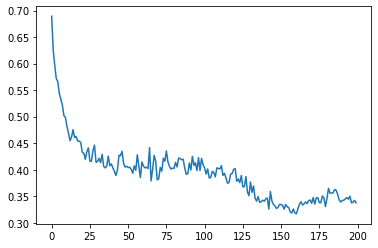

In [8]:
plt.plot([x.detach().cpu() for x in train_losses])

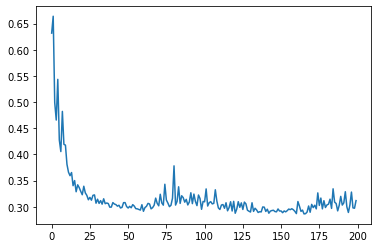

In [9]:
plt.plot([x.detach().cpu() for x in val_losses])